# 📊 Data Preprocessing, Stationarity Tests, and Feature Engineering

This notebook performs **data preprocessing and statistical analysis** on the Shanghai Stock Exchange Index (000001.SS) for the period `2010-01-04` to `2020-01-23`, as described in **Section 2.1 of the paper**:

**"The Application and Effectiveness of Machine Learning and Deep Learning Methods in Analyzing and Predicting the Shanghai Stock Index"**

---

## 🧱 Contents

### ✅ Data Loading
- Download historical stock data from Yahoo Finance

### ✅ Statistical Analysis
- Histogram, boxplots, skewness, and kurtosis analysis
- Outlier detection using Z-Score
- Seasonal and weekday return significance using t-tests

### ✅ Stationarity Checks
- ADF (Augmented Dickey-Fuller) Test
- KPSS (Kwiatkowski–Phillips–Schmidt–Shin) Test
- Variance Ratio Test
- Phillips-Perron Test
- Seasonal Decomposition (Multiplicative and Additive)
- Lag-based ACF/PACF plots (before/after differencing)

### ✅ Transformations & Feature Engineering
- First-order differencing
- Seasonal Moving Average (window=3)
- Seasonal detrending: `Column - Seasonal_MA`
- Min-Max Scaling
- Lag features: `Adj Close_lag_6` to `lag_3`
- ADF test on transformed features

---

## 🔍 Paper Context
This notebook corresponds to **Section 2.1–2.1.2** and supports the empirical evidence for:
- Stationarity assumptions of traditional time series models (e.g., ARIMA)
- Justification for using differencing and detrending
- Feature generation for downstream machine learning models (RF, XGBoost, CNN-BiLSTM)

---

## 🧪 Output
- Cleaned, transformed, and feature-enriched dataset ready for modeling
- Statistical insight into temporal dependencies and seasonal patterns in the Shanghai stock market data


In [1]:
!pip install yfinance

In [6]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 5.4 MB/s eta 0:00:00


In [2]:
!pip install scipy

In [3]:
!pip install yfinance

In [7]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from math import sqrt
from scipy import stats
from scipy.stats import kurtosis, skew
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from arch.unitroot import PhillipsPerron, VarianceRatio


In [8]:
#Getting data from Yahoo Finance

start = '2010-01-04'
end = '2020-01-23'

data = yf.download('000001.SS', start, end)

data = data.reset_index()

data =data.dropna()

data

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,3289.750000,3295.279053,3243.319092,3243.760010,3243.760010,109400
1,2010-01-05,3254.468018,3290.511963,3221.461914,3282.178955,3282.178955,126200
2,2010-01-06,3277.517090,3295.867920,3253.043945,3254.215088,3254.215088,123600
3,2010-01-07,3253.990967,3268.819092,3176.707031,3192.775879,3192.775879,128600
4,2010-01-08,3177.259033,3198.919922,3149.017090,3195.997070,3195.997070,98400
...,...,...,...,...,...,...,...
2437,2020-01-16,3095.733887,3096.372070,3070.884033,3074.081055,3074.081055,203400
2438,2020-01-17,3081.464111,3091.951904,3067.252930,3075.496094,3075.496094,190300
2439,2020-01-20,3082.113037,3096.311035,3070.479980,3095.787109,3095.787109,210500
2440,2020-01-21,3085.790039,3085.790039,3051.229980,3052.139893,3052.139893,234800


In [9]:
# Select 'Adj Close' column
adj_close = data['Adj Close']

# Calculate Phillips-Perron test (ADF test)
pp = PhillipsPerron(adj_close)
print(f'Phillips-Perron test statistic: {pp.stat}, p-value: {pp.pvalue}')

# Calculate Variance Ratio test (BDS test)
vr = VarianceRatio(adj_close, lags=2)
print(f'Variance Ratio test statistic: {vr.stat}, p-value: {vr.pvalue}')


Phillips-Perron test statistic: -2.3240783314992637, p-value: 0.16431977627878358
Variance Ratio test statistic: 1.3812791851579072, p-value: 0.16719313563862803




- **Phillips-Perron Test (ADF)**: This test is used to check for the presence of a unit root (or non-stationarity) in a time series. The p-value is **0.164**, which is greater than 0.05. Therefore, we cannot reject the null hypothesis that the time series has a unit root. This result suggests that the time series may be non-stationary.

- **Variance Ratio Test (BDS)**: This test is used to check for the presence of autocorrelation in a time series. The p-value is **0.167**, which is greater than 0.05. Therefore, we cannot reject the null hypothesis that the time series has no autocorrelation. This result suggests that the time series may have autocorrelation.


In [ ]:
# Calculate kurtosis and skewness
adj_close_kurtosis = kurtosis(data['Adj Close'])
adj_close_skewness = skew(data['Adj Close'])

print(f"Kurtosis of Adjusted Close: {adj_close_kurtosis}")
print(f"Skewness of Adjusted Close: {adj_close_skewness}")

Kurtosis of Adjusted Close: 1.5239890293523244
Skewness of Adjusted Close: 0.7482437870151281


The results of the kurtosis and skewness calculations provide insights into the distribution characteristics of the adjusted closing prices for the Shanghai Composite Index (000001.SS) over the specified period. Here's how to interpret these values:

### Kurtosis
**Value: 1.5239890293523244**

- **Interpretation**:
  - Kurtosis measures the "tailedness" of the distribution of the data. In other words, it indicates how much of the variance in the data is due to extreme values (outliers).
  - A kurtosis value of 3 indicates a normal distribution (mesokurtic).
  - A value greater than 3 indicates a distribution with heavier tails than a normal distribution (leptokurtic), which suggests more frequent extreme values.
  - A value less than 3 indicates a distribution with lighter tails than a normal distribution (platykurtic), which suggests fewer extreme values.
- **Result Interpretation**:
  - A kurtosis of 1.52 suggests that the distribution of the adjusted closing prices is platykurtic. This means the distribution has lighter tails and fewer extreme values compared to a normal distribution.

### Skewness
**Value: 0.7482437870151281**

- **Interpretation**:
  - Skewness measures the asymmetry of the distribution of the data.
  - A skewness value of 0 indicates a perfectly symmetrical distribution.
  - A positive skewness value indicates a distribution with a tail on the right side (right-skewed or positively skewed), where the mean and median are greater than the mode.
  - A negative skewness value indicates a distribution with a tail on the left side (left-skewed or negatively skewed), where the mean and median are less than the mode.
- **Result Interpretation**:
  - A skewness of 0.75 indicates that the distribution of the adjusted closing prices is moderately right-skewed. This means there are more values on the left side of the distribution with a longer tail on the right side. In other words, there are more frequent smaller values and a few large values that stretch the tail on the right.

### Summary
- The adjusted closing prices for the Shanghai Composite Index over the specified period have a distribution that is lighter-tailed than a normal distribution (platykurtic) and moderately skewed to the right (positive skewness).
- This suggests that extreme values (outliers) are less frequent than in a normal distribution, and there are more smaller values with a few larger values causing the right tail.

These statistical insights can help in understanding the behavior of the stock prices and potential risks associated with extreme price movements.

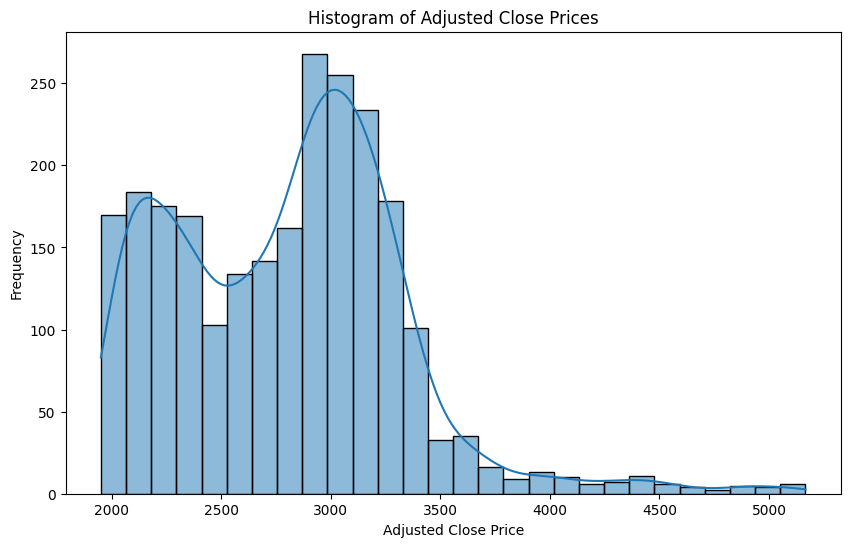

In [ ]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data['Adj Close'], kde=True)
plt.title('Histogram of Adjusted Close Prices')
plt.xlabel('Adjusted Close Price')
plt.ylabel('Frequency')
plt.show()

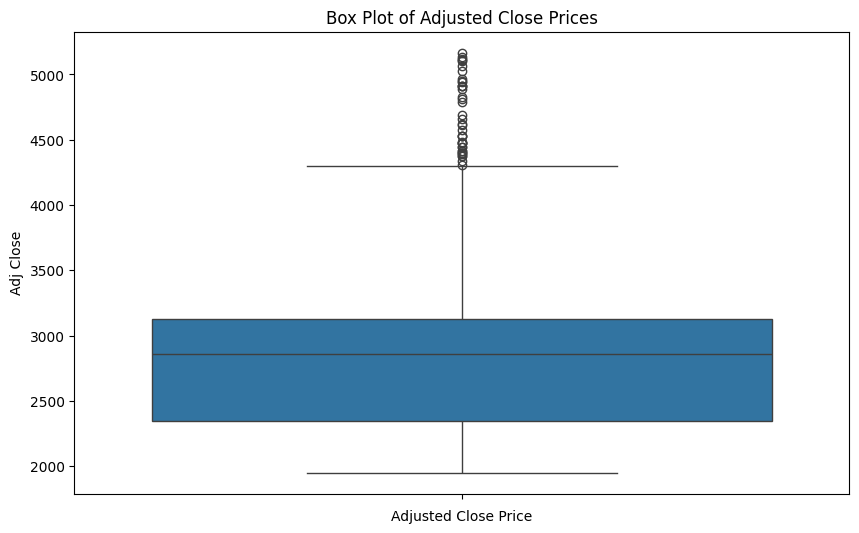

In [ ]:
# Plotting the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data['Adj Close'])
plt.title('Box Plot of Adjusted Close Prices')
plt.xlabel('Adjusted Close Price')
plt.show()

In [ ]:
# Calculating Z-Score for each column
z_scores = zscore(data['Adj Close'])

# Creating a training dataframe without outliers
data_without_outliers = data[np.abs(z_scores) < 3]


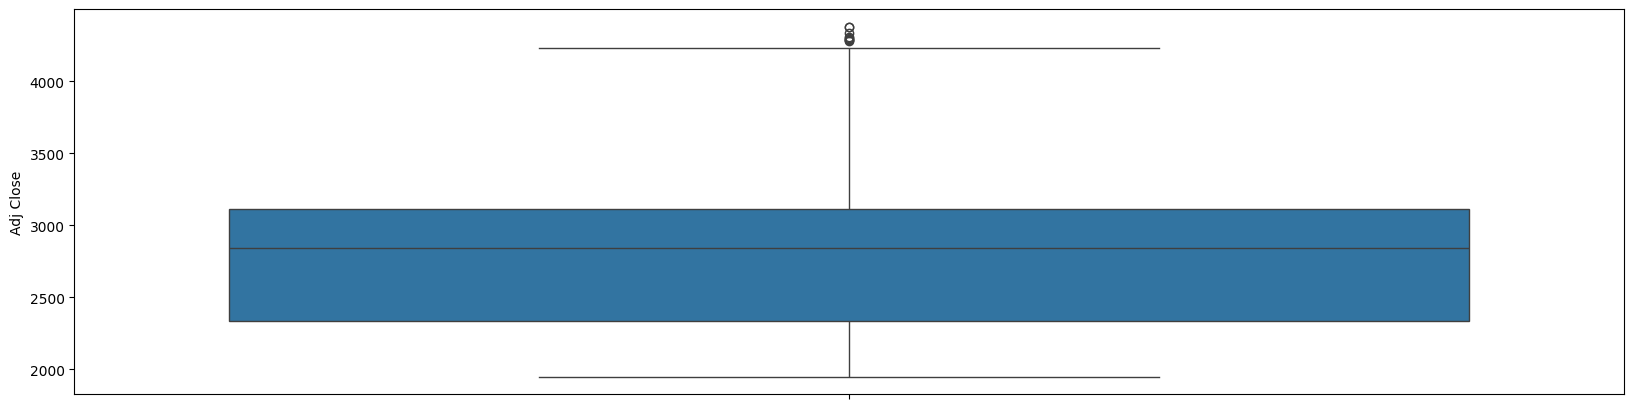

In [ ]:
# Plotting the boxplot of Adjusted Close prices after outlier removal
# to visualize the distribution and remaining spread in cleaned data

fig = plt.subplots(figsize=(20, 5))
ax = sns.boxplot(data_without_outliers['Adj Close'],whis=1.5)

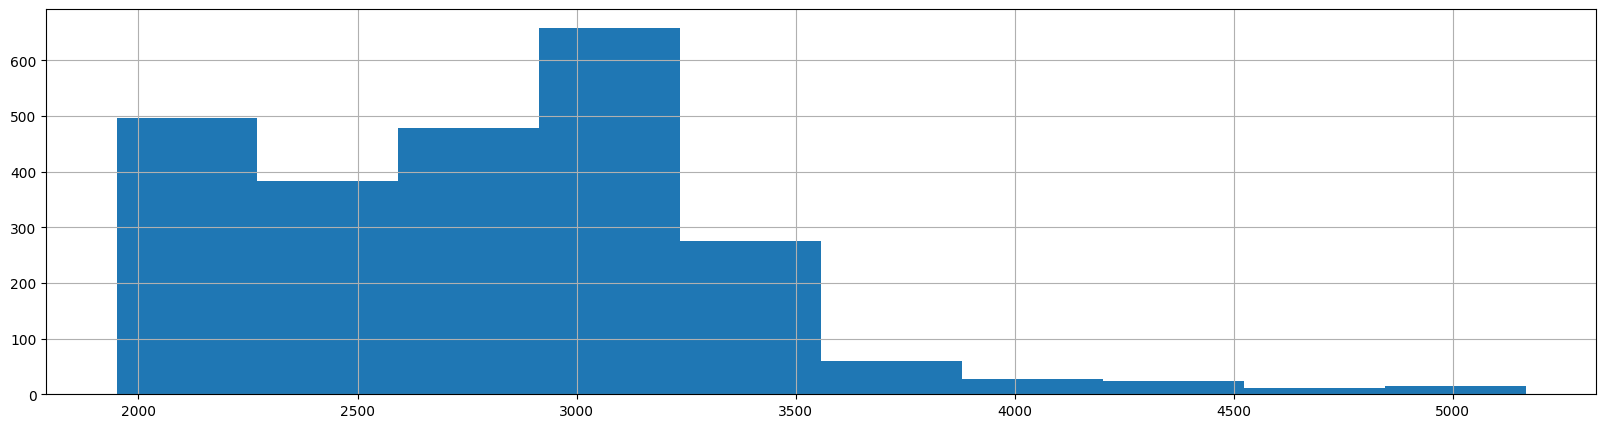

In [ ]:
# Plotting the histogram of Adjusted Close prices to observe overall distribution

fig =data['Adj Close'].hist(figsize=(20, 5))

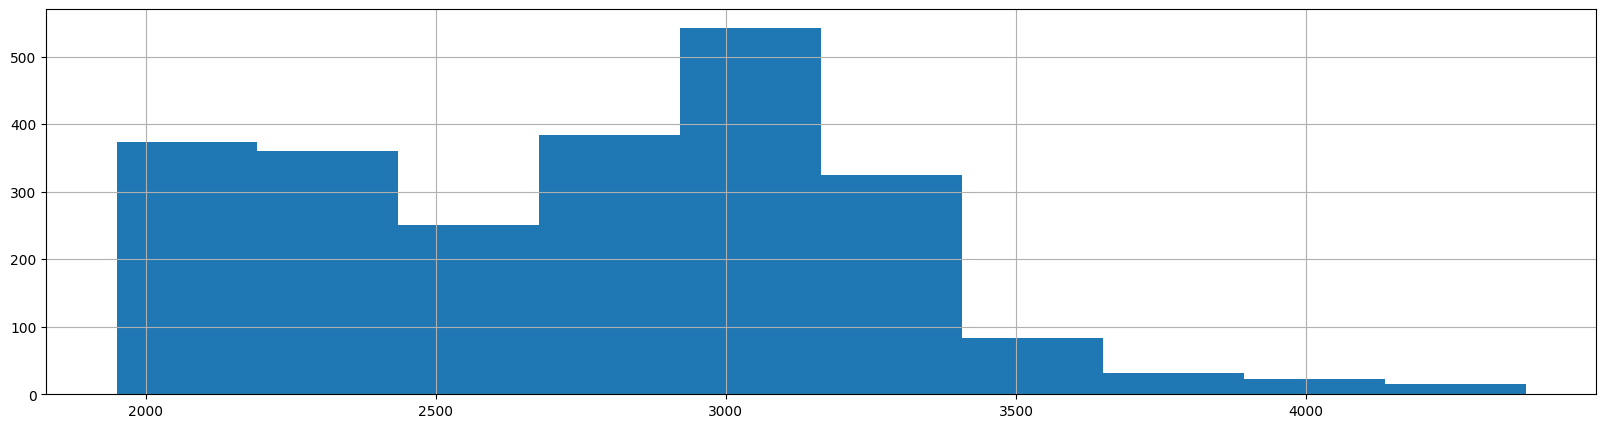

In [ ]:
# Plotting the histogram of Adjusted Close prices after removing outliers

fig = data_without_outliers['Adj Close'].hist(figsize=(20, 5))

In [ ]:
price=data['Adj Close']
price=price.dropna()

In [ ]:
# Create an instance of the MinMaxScaler class
scaler = MinMaxScaler()

# Fit and transform the desired columns
# Reshape price to a 2D array before scaling
scaled_price = scaler.fit_transform(price.values.reshape(-1, 1))

scaled_price


array([[0.40224255],
       [0.41418748],
       [0.40549316],
       ...,
       [0.35623591],
       [0.34266544],
       [0.34534395]])

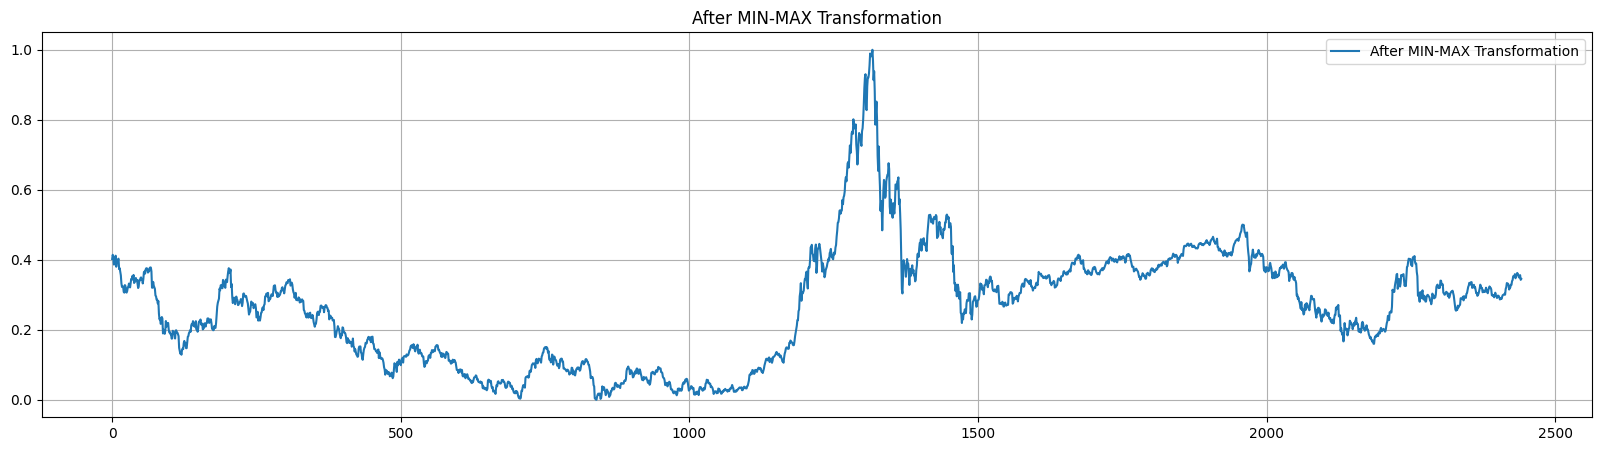

In [ ]:
# Display the plot after MIN-MAX transformation
plt.figure(figsize=(20, 5))
plt.plot(scaled_price, label='After MIN-MAX Transformation')
plt.legend(loc='best')
plt.title('After MIN-MAX Transformation')
plt.grid()
plt.show()


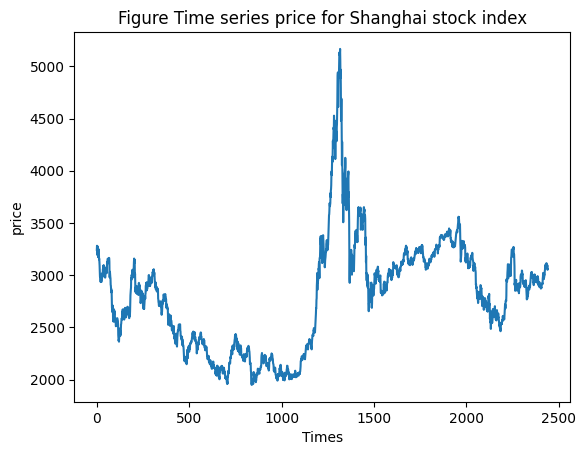

In [ ]:
# Plotting the time series of Adjusted Close prices for the Shanghai Stock Index

price.plot()
plt.title("Figure Time series price for Shanghai stock index")
plt.xlabel("Times")
plt.ylabel("price")

plt.show()

In [ ]:
price.describe() #gives the statistical information of the time series

count    2442.000000
mean     2801.280363
std       529.825074
min      1950.011963
25%      2345.375244
50%      2859.838501
75%      3128.352600
max      5166.350098
Name: Adj Close, dtype: float64

Text(0, 0.5, 'Autocovariance')

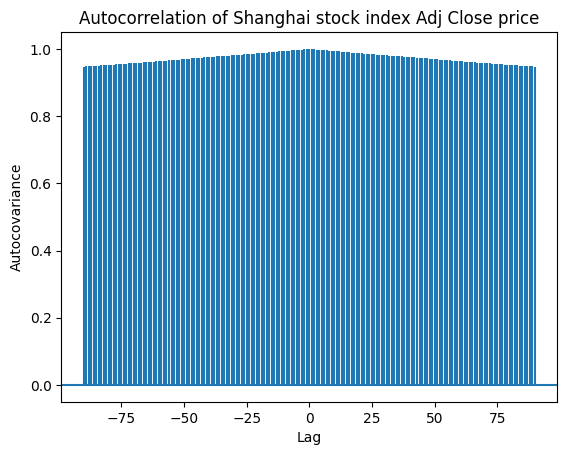

In [ ]:
#Autocorrelation Analysis of the Adjusted Close Price for the Shanghai Stock Index
plt.acorr(price, maxlags = 90)
plt.title('Autocorrelation of Shanghai stock index Adj Close price')
plt.xlabel('Lag')
plt.ylabel('Autocovariance')

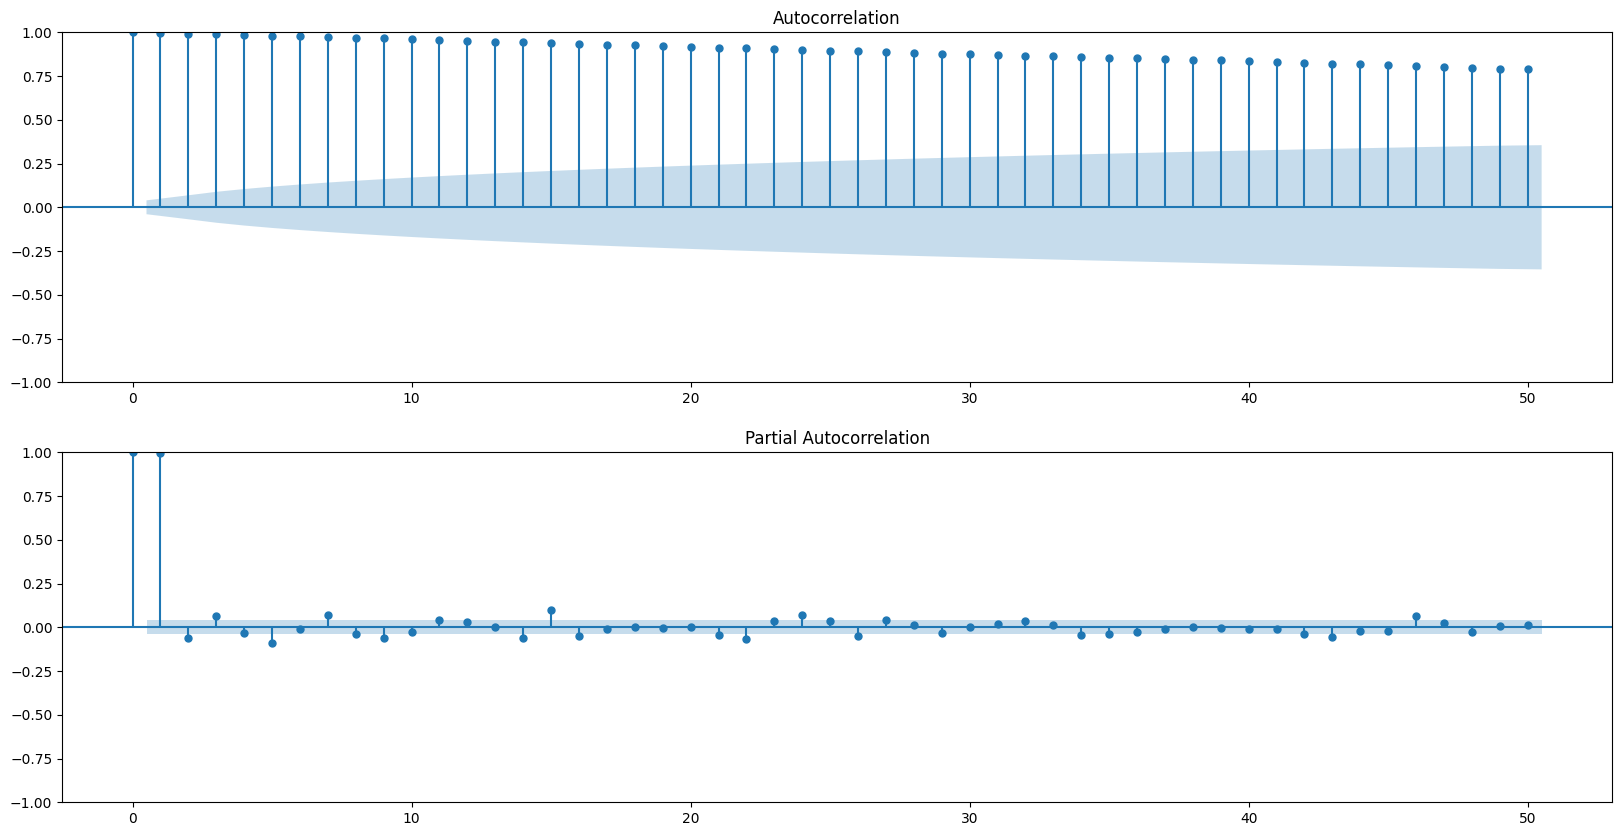

In [ ]:
# Plotting ACF and PACF of Adjusted Close prices to analyze autocorrelation and partial autocorrelation

fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(price.dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(price.dropna(), lags=50, ax=ax[1])
plt.show()

# ***estationary exam***

In [ ]:
# Performing Augmented Dickey-Fuller test to check stationarity of the Adjusted Close price series

result = adfuller(price)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -2.190614
p-value: 0.209670


In [ ]:
# Performing KPSS test to assess the stationarity of the Adjusted Close price series

kpss_test = kpss(price)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 1.985547
Critical Values @ 0.05: 0.46
p-value: 0.010000


<ipython-input-44-c6e7e7777470>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(price)


the results show price is not stationary

In [ ]:
kpss_test = kpss(price.diff().dropna())

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.079441
Critical Values @ 0.05: 0.46
p-value: 0.100000


<ipython-input-45-662a75802d86>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(price.diff().dropna())


In [ ]:
result = adfuller((price.diff().dropna()),regression='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -9.854117
p-value: 0.000000


the results show after one diff price becomes stationary

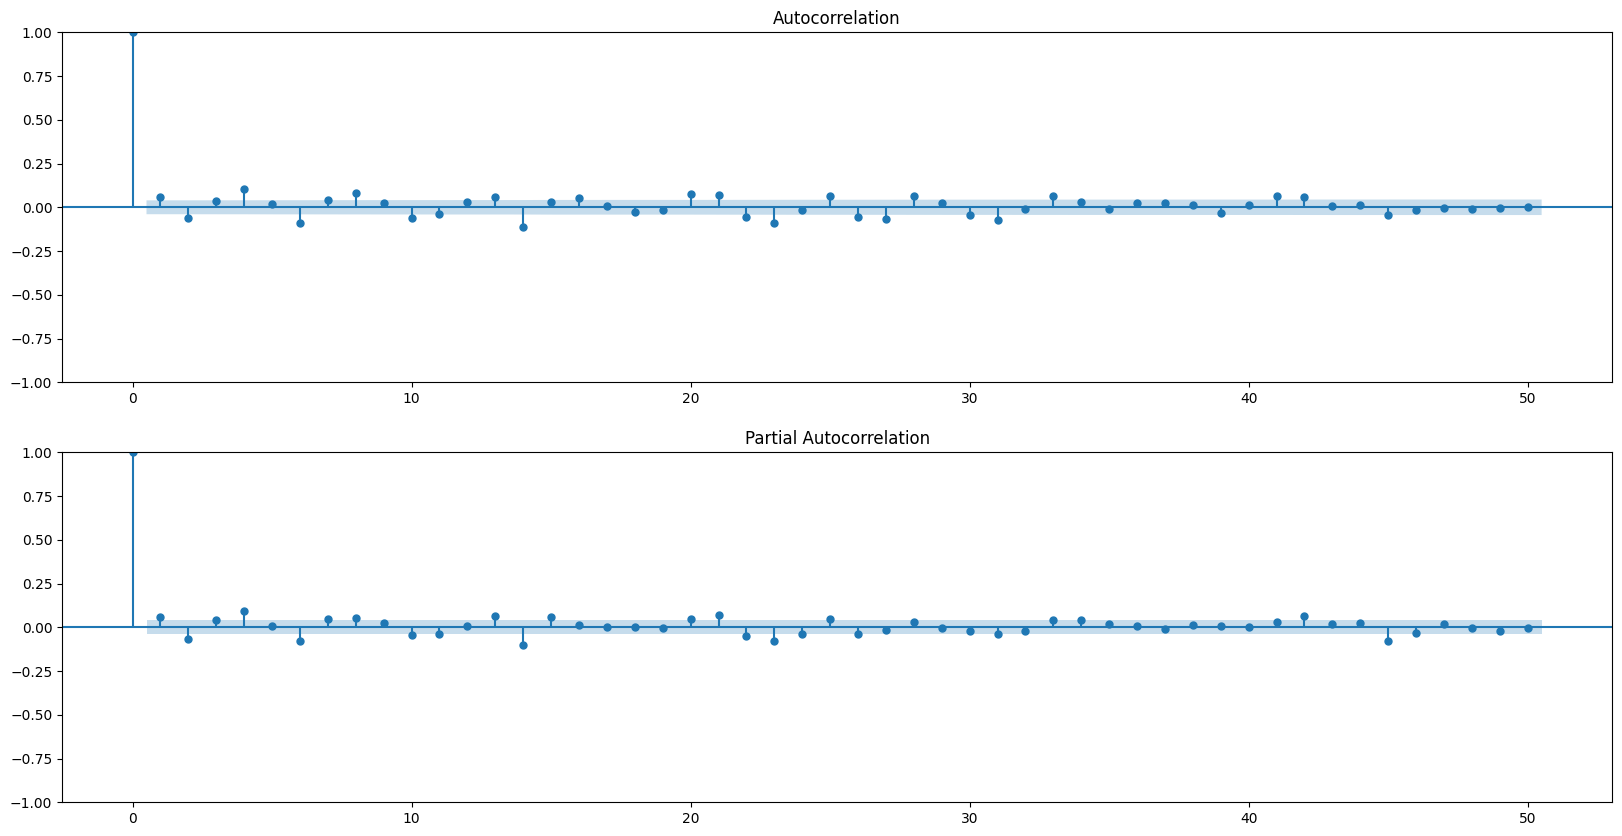

In [ ]:
#we use price.diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(price.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(price.diff().dropna(), lags=50, ax=ax[1])
plt.show()

In [ ]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column 'DayOfWeek' that indicates the day of the week
data['DayOfWeek'] = data['Date'].dt.dayofweek

# Check the data for Saturdays
saturday_data = data[data['DayOfWeek'] == 5]
print(f"Number of Saturdays with data: {len(saturday_data)}")

# Check the data for Sundays
sunday_data = data[data['DayOfWeek'] == 6]
print(f"Number of Sundays with data: {len(sunday_data)}")


Number of Saturdays with data: 0
Number of Sundays with data: 0


# ***weekly effect***

In [ ]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column 'DayOfWeek' that indicates the day of the week
data['DayOfWeek'] = data['Date'].dt.dayofweek

results = {}

for i in range(7):
    # Separate the data for the current day
    day_data = data[data['DayOfWeek'] == i]['Adj Close']

    # Remove NaN values from the data
    day_data_clean = day_data.dropna()

    # Perform a t-test for the current day's data and all data
    t_stat, p_val = stats.ttest_ind(day_data_clean, data['Adj Close'].dropna(), equal_var=False)

    results[i] = {'t_stat': t_stat, 'p_val': p_val}

for day, result in results.items():
    print(f"Day {day}: t statistic = {result['t_stat']}, p value = {result['p_val']}")



Day 0: t statistic = -0.08338140626006171, p value = 0.9335732273588562
Day 1: t statistic = 0.20447688099545977, p value = 0.8380403010233294
Day 2: t statistic = 0.2481003554438417, p value = 0.804128611383996
Day 3: t statistic = -0.10722036192612136, p value = 0.914644808860338
Day 4: t statistic = -0.2705111729683245, p value = 0.7868466448414738
Day 5: t statistic = nan, p value = nan
Day 6: t statistic = nan, p value = nan


# ***seasonal effect***

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column 'Month' that shows the month
data['Month'] = data['Date'].dt.month

results = {}

# Loop for each season of the year
for i in range(1, 5):
    # Separate the current season's data
    season_data = data[data['Month'].isin(range(i*3-2, i*3+1))]['Adj Close']

    # Remove NaN from the data
    season_data_clean = season_data.dropna()

    # Perform a t-test for the current season's data and all data
    t_stat, p_val = stats.ttest_ind(season_data_clean, data['Adj Close'].dropna(), equal_var=False)

    # Add the results to the dictionary
    results[i] = {'t_stat': t_stat, 'p_val': p_val}

# Print the results
for season, result in results.items():
    print(f"Season {season}: t statistic = {result['t_stat']}, p value = {result['p_val']}")


Season 1: t statistic = 1.4823099300916376, p value = 0.13855587958200288
Season 2: t statistic = 3.0856961029057346, p value = 0.0021015599116911373
Season 3: t statistic = -3.883737638247106, p value = 0.00010914881156900065
Season 4: t statistic = -1.3217291749755729, p value = 0.1865584024592096


# ***Check Stationary***

In [ ]:
def make_stationary_Seasonal_Moving_Average_3(data, column):
    # Calculate the seasonal moving average
    data[f'{column}_Seasonal_Moving_Average_3'] = data[column].rolling(window=3).mean()

    # Remove the seasonal trend from the data
    data[f'{column}_Stationary_Seasonal_Moving_Average_3'] = data[column] - data[f'{column}_Seasonal_Moving_Average_3']

    return data

def check_stationarity(data, columns):
    for column in columns:
        result = adfuller(data[column].dropna())
        print(f'ADF Statistic for {column}: {result[0]}')
        print(f'p-value for {column}: {result[1]}')
        print('------------------------------------')

# Create a new column named ''diff Adj Close'' that is the first difference of 'Adj Close'
data['diff Adj Close'] = data['Adj Close'].diff().dropna()

# Define the columns to check for stationarity
columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','diff Adj Close']

# Call the function to check stationarity
check_stationarity(data, columns)

# Create a stationary series from each non-stationary series
non_stationary_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close']
for column in non_stationary_columns:
    data = make_stationary_Seasonal_Moving_Average_3(data, column)

# Check the stationarity of the new series
stationary_columns = [f'{column}_Stationary_Seasonal_Moving_Average_3' for column in non_stationary_columns]
check_stationarity(data, stationary_columns)


ADF Statistic for Open: -2.2461741474923977
p-value for Open: 0.18991551772594067
------------------------------------
ADF Statistic for High: -2.1806616521016764
p-value for High: 0.2133388732323288
------------------------------------
ADF Statistic for Low: -2.136877668791221
p-value for Low: 0.2299466912520568
------------------------------------
ADF Statistic for Close: -2.1906137799572543
p-value for Close: 0.20966973385174315
------------------------------------
ADF Statistic for Adj Close: -2.1906137799572543
p-value for Adj Close: 0.20966973385174315
------------------------------------
ADF Statistic for Volume: -3.206516759551962
p-value for Volume: 0.019610548910299414
------------------------------------
ADF Statistic for diff Adj Close: -9.837497369318521
p-value for diff Adj Close: 4.851406422117942e-17
------------------------------------
ADF Statistic for Open_Stationary_Seasonal_Moving_Average_3: -10.495665981127948
p-value for Open_Stationary_Seasonal_Moving_Average_3:

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,DayOfWeek,Month,diff Adj Close,Open_Seasonal_Moving_Average_3,Open_Stationary_Seasonal_Moving_Average_3,High_Seasonal_Moving_Average_3,High_Stationary_Seasonal_Moving_Average_3,Low_Seasonal_Moving_Average_3,Low_Stationary_Seasonal_Moving_Average_3,Close_Seasonal_Moving_Average_3,Close_Stationary_Seasonal_Moving_Average_3,Adj Close_Seasonal_Moving_Average_3,Adj Close_Stationary_Seasonal_Moving_Average_3
0,2010-01-04,3289.750000,3295.279053,3243.319092,3243.760010,3243.760010,109400,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,3254.468018,3290.511963,3221.461914,3282.178955,3282.178955,126200,1,1,38.418945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-06,3277.517090,3295.867920,3253.043945,3254.215088,3254.215088,123600,2,1,-27.963867,3273.911702,3.605387,3293.886312,1.981608,3239.274984,13.768962,3260.051351,-5.836263,3260.051351,-5.836263
3,2010-01-07,3253.990967,3268.819092,3176.707031,3192.775879,3192.775879,128600,3,1,-61.439209,3261.992025,-8.001058,3285.066325,-16.247233,3217.070964,-40.363932,3243.056641,-50.280762,3243.056641,-50.280762
4,2010-01-08,3177.259033,3198.919922,3149.017090,3195.997070,3195.997070,98400,4,1,3.221191,3236.255697,-58.996663,3254.535645,-55.615723,3192.922689,-43.905599,3214.329346,-18.332275,3214.329346,-18.332275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437,2020-01-16,3095.733887,3096.372070,3070.884033,3074.081055,3074.081055,203400,3,1,-15.958984,3106.523600,-10.789714,3110.493652,-14.121582,3086.176351,-15.292318,3090.313721,-16.232666,3090.313721,-16.232666
2438,2020-01-17,3081.464111,3091.951904,3067.252930,3075.496094,3075.496094,190300,4,1,1.415039,3093.455973,-11.991862,3098.754639,-6.802734,3073.392334,-6.139404,3079.872396,-4.376302,3079.872396,-4.376302
2439,2020-01-20,3082.113037,3096.311035,3070.479980,3095.787109,3095.787109,210500,0,1,20.291016,3086.437012,-4.323975,3094.878337,1.432699,3069.538981,0.940999,3081.788086,13.999023,3081.788086,13.999023
2440,2020-01-21,3085.790039,3085.790039,3051.229980,3052.139893,3052.139893,234800,1,1,-43.647217,3083.122396,2.667643,3091.350993,-5.560954,3062.987630,-11.757650,3074.474365,-22.334473,3074.474365,-22.334473


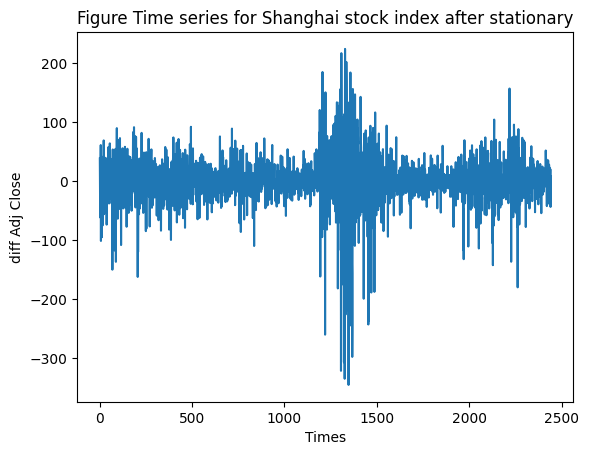

In [ ]:
# Plotting the differenced Adjusted Close price to visualize the stationary time series

plt.plot(data['diff Adj Close'])

plt.title("Figure Time series for Shanghai stock index after stationary")
plt.xlabel("Times")
plt.ylabel("diff Adj Close")

plt.show()

In [ ]:
# Displaying summary information about the dataset, including column types and non-null counts

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2442 entries, 0 to 2441
Data columns (total 20 columns):
 #   Column                                          Non-Null Count  Dtype         
---  ------                                          --------------  -----         
 0   Date                                            2442 non-null   datetime64[ns]
 1   Open                                            2442 non-null   float64       
 2   High                                            2442 non-null   float64       
 3   Low                                             2442 non-null   float64       
 4   Close                                           2442 non-null   float64       
 5   Adj Close                                       2442 non-null   float64       
 6   Volume                                          2442 non-null   int64         
 7   DayOfWeek                                       2442 non-null   int32         
 8   Month                                           

In [ ]:
# Generating descriptive statistics for the dataset (mean, std, min, max, etc.)

data.describe()

,Date,Open,High,Low,Close,Adj Close,Volume,DayOfWeek,Month,diff Adj Close,Open_Seasonal_Moving_Average_3,Open_Stationary_Seasonal_Moving_Average_3,High_Seasonal_Moving_Average_3,High_Stationary_Seasonal_Moving_Average_3,Low_Seasonal_Moving_Average_3,Low_Stationary_Seasonal_Moving_Average_3,Close_Seasonal_Moving_Average_3,Close_Stationary_Seasonal_Moving_Average_3,Adj Close_Seasonal_Moving_Average_3,Adj Close_Stationary_Seasonal_Moving_Average_3
count,2442,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2441.000000,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000
mean,2015-01-16 08:16:30.663390464,2798.289087,2820.799093,2776.136156,2801.280363,2801.280363,170969.492219,2.011466,6.560197,-0.074971,2797.987585,-0.086875,2820.501201,-0.089072,2775.847215,-0.085038,2800.988605,-0.086676,2800.988605,-0.086676
min,2010-01-04 00:00:00,1935.515991,1959.157959,1849.652954,1950.011963,1950.011963,39600.000000,0.000000,1.000000,-345.349854,1948.371989,-325.061686,1967.754679,-265.044352,1904.949300,-290.992513,1953.671672,-277.394206,1953.671672,-277.394206
25%,2012-07-12 06:00:00,2342.401978,2362.043701,2322.053101,2345.375244,2345.375244,93625.000000,1.000000,4.000000,-15.916016,2340.258993,-12.734375,2359.828003,-11.275472,2326.897522,-12.804342,2345.833354,-12.434285,2345.833354,-12.434285
50%,2015-01-19 12:00:00,2853.631958,2880.465088,2827.875000,2859.838501,2859.838501,137250.000000,2.000000,7.000000,1.281982,2857.456543,0.404012,2879.972005,1.028809,2832.505656,0.507324,2861.932821,0.211466,2861.932821,0.211466
75%,2017-07-20 18:00:00,3125.396912,3144.810486,3102.902039,3128.352600,3128.352600,197625.000000,3.000000,9.000000,17.473145,3119.358500,14.324992,3146.506714,12.037659,3103.286194,13.925842,3126.731832,14.361877,3126.731832,14.361877
max,2020-01-22 00:00:00,5174.417969,5178.190918,5103.400879,5166.350098,5166.350098,857100.000000,4.000000,12.000000,224.192139,5139.733561,232.689290,5159.147624,190.236003,5067.636068,222.099609,5131.326335,179.694661,5131.326335,179.694661
std,NaN,529.126115,536.868081,519.263446,529.825074,529.825074,121599.039090,1.406906,3.443918,42.613359,528.369144,33.680807,536.375957,29.089744,518.553672,33.163856,529.151489,32.511974,529.151489,32.511974


Text(0, 0.5, 'ACF')

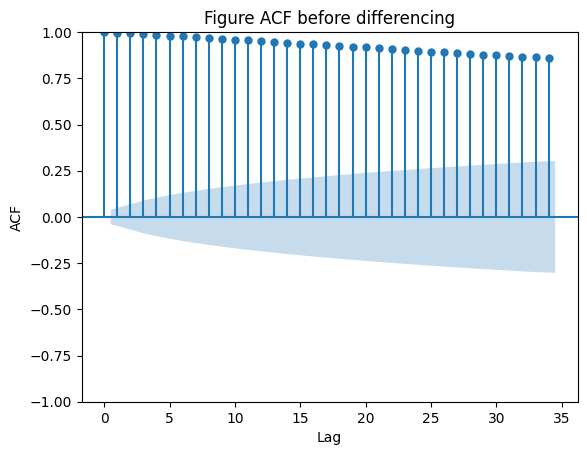

In [ ]:
# Plotting the autocorrelation function (ACF) of Adjusted Close prices before differencing

price=data['Adj Close'].dropna()
plot_acf(price).show()

plt.title("Figure ACF before differencing")
plt.xlabel("Lag")
plt.ylabel("ACF")

#Time Series Decomposition of Stock Prices

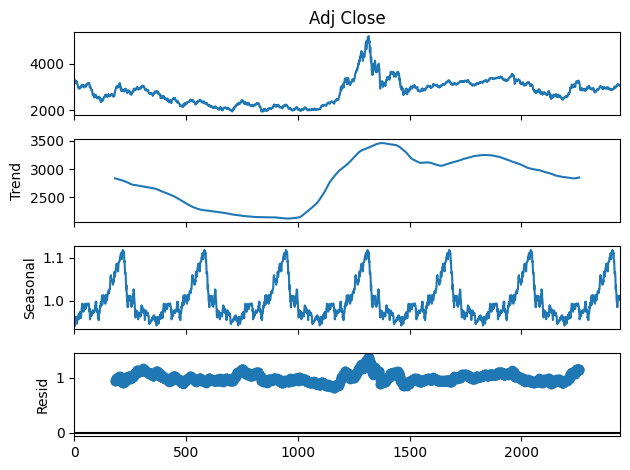

In [ ]:
# Performing multiplicative seasonal decomposition of the Adjusted Close price series

result = seasonal_decompose(price, model='multiplicative', period=365)


result.plot()
plt.show()


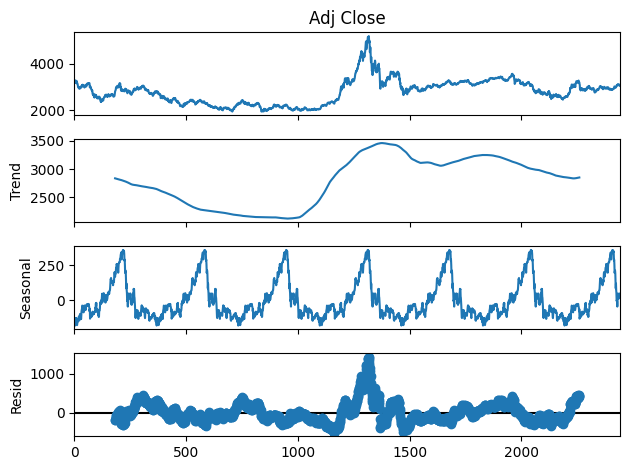

In [ ]:
# Performing additive seasonal decomposition of the Adjusted Close price series

result = seasonal_decompose(price, model='additive', period=365)

result.plot()
plt.show()


<Axes: >

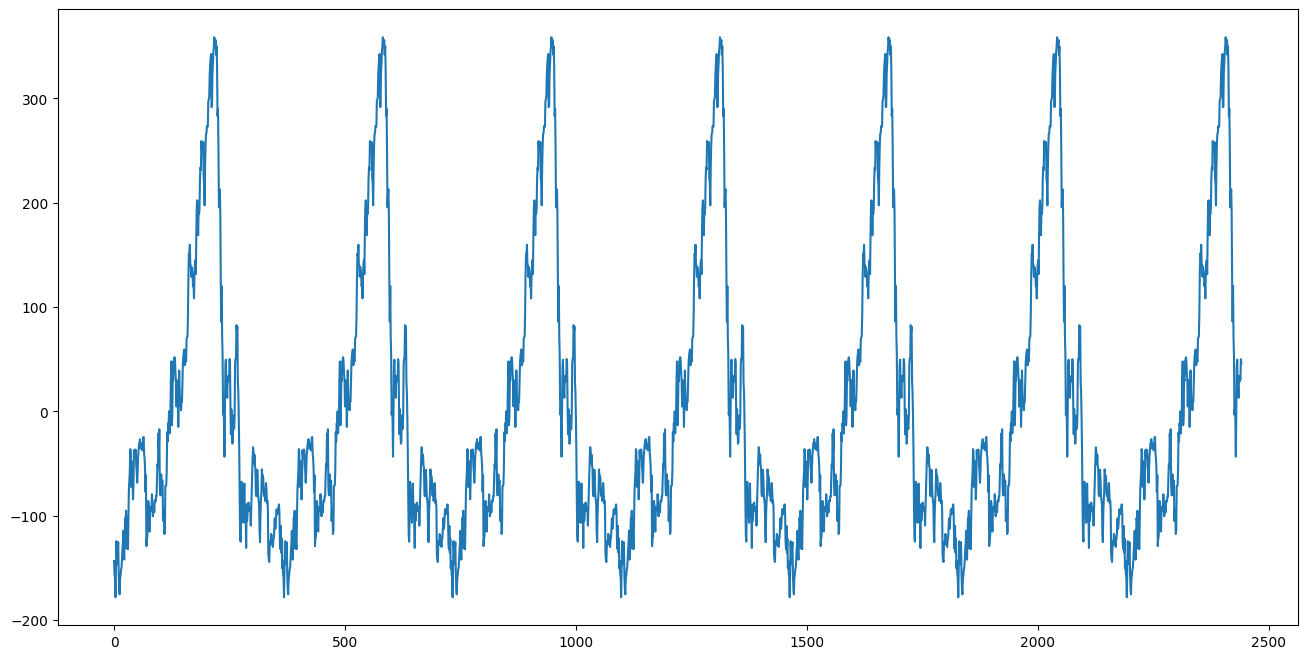

In [ ]:
# Plotting the seasonal component extracted from the time series decomposition

result.seasonal.plot(figsize=(16,8))

ADF Statistic for Open: -2.2682921027014395
p-value for Open: 0.1823983669037182
------------------------------------
ADF Statistic for High: -2.2200608711676844
p-value for High: 0.19904524552529085
------------------------------------
ADF Statistic for Low: -2.1685911618256446
p-value for Low: 0.21784185250152
------------------------------------
ADF Statistic for Close: -2.2282492386376225
p-value for Close: 0.1961528090073994
------------------------------------
ADF Statistic for Adj Close: -2.2282492386376225
p-value for Adj Close: 0.1961528090073994
------------------------------------
ADF Statistic for Volume: -3.224796329167038
p-value for Volume: 0.01859349442515652
------------------------------------
ADF Statistic for diff Adj Close: -9.73440267205183
p-value for diff Adj Close: 8.828796352463357e-17
------------------------------------
ADF Statistic for Open_Stationary_Seasonal_Moving_Average_3: -10.440775032277335
p-value for Open_Stationary_Seasonal_Moving_Average_3: 1.52

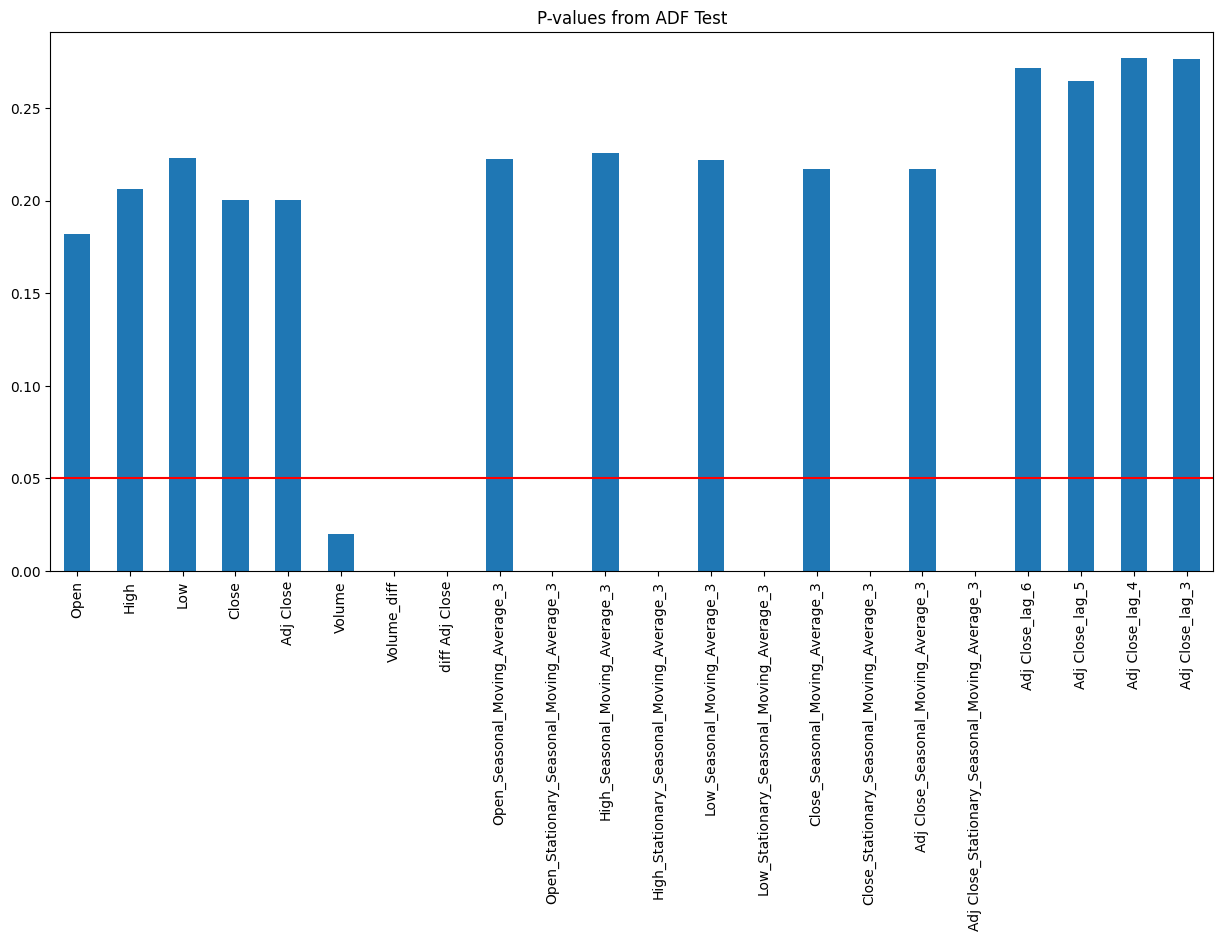

In [ ]:
# Function to perform Augmented Dickey-Fuller test on a list of columns to assess stationarity
def check_stationarity(data, columns):
    for column in columns:
        result = adfuller(data[column].dropna())
        print(f'ADF Statistic for {column}: {result[0]}')
        print(f'p-value for {column}: {result[1]}')
        print('------------------------------------')

# Function to create a stationary version of a column using a 3-period seasonal moving average
def make_stationary_Seasonal_Moving_Average_3(data, column):
    data_copy = data.copy()
    data_copy[f'{column}_Seasonal_Moving_Average_3'] = data_copy[column].rolling(window=3).mean()
    data_copy[f'{column}_Stationary_Seasonal_Moving_Average_3'] = data_copy[column] - data_copy[f'{column}_Seasonal_Moving_Average_3']
    return data_copy

# Function to create lagged features (log-transformed) for a specified column
def create_lag_columns(data, column, max_lag):
    data_copy = data.copy()
    for i in range(max_lag, 2, -1):
        data_copy[f'{column}_lag_{i}'] = np.log(data_copy[column].shift(i))
    return data_copy

# Function to plot p-values of ADF test results for various features
def plot_p_values(df_stats):
    df_stats['P-value'].plot(kind='bar', figsize=(15, 7))
    plt.axhline(y=0.05, color='r', linestyle='-')
    plt.title('P-values from ADF Test')
    plt.show()

# Define the columns to check for stationarity
columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','diff Adj Close']

# Call the function to check stationarity
check_stationarity(data, columns)

# Create a stationary series from each non-stationary series
non_stationary_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close']
for column in non_stationary_columns:
    data = make_stationary_Seasonal_Moving_Average_3(data, column)

# Check the stationarity of the new series
stationary_columns = [f'{column}_Stationary_Seasonal_Moving_Average_3' for column in non_stationary_columns]
check_stationarity(data, stationary_columns)

# Create the difference of 'Volume' column
data['Volume_diff'] = data['Volume'].diff()

# Drop the first row which will be NaN after differencing
data = data.dropna()

# Run the ADF test again on the differenced 'Volume' column
dftest = adfuller(data['Volume_diff'], autolag='AIC')

# Check if the p-value is less than 0.05, which indicates stationarity
if dftest[1] < 0.05:
    print("The differenced Volume column is stationary with a p-value of:", dftest[1])
else:
    print("The differenced Volume column is not stationary.")

# Create lag columns
data = create_lag_columns(data, "Adj Close", 6)

# Drop rows with missing values
data = data.dropna()

# Define the columns
columns = [ 'Open','High', 'Low', 'Close', 'Adj Close', 'Volume','Volume_diff', 'diff Adj Close',
           'Open_Seasonal_Moving_Average_3', 'Open_Stationary_Seasonal_Moving_Average_3',
           'High_Seasonal_Moving_Average_3', 'High_Stationary_Seasonal_Moving_Average_3',
           'Low_Seasonal_Moving_Average_3', 'Low_Stationary_Seasonal_Moving_Average_3',
           'Close_Seasonal_Moving_Average_3', 'Close_Stationary_Seasonal_Moving_Average_3',
           'Adj Close_Seasonal_Moving_Average_3', 'Adj Close_Stationary_Seasonal_Moving_Average_3',
            'Adj Close_lag_6', 'Adj Close_lag_5', 'Adj Close_lag_4', 'Adj Close_lag_3']

# Create a DataFrame to store the ADF test results
df_stats = pd.DataFrame(columns=['P-value'], index=columns)

# Run the ADF test for each column and store the results in df_stats
for col in columns:
  dftest = adfuller(data[col], autolag='AIC')
  df_stats.loc[col] = dftest[1]

# Plot the p-values
plot_p_values(df_stats)
